## Initialization

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Project description

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. 

## Load Data

The dataset is stored in the `/datasets/faces/` folder, It contains:
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, we will avoid reading them all at once, which would greatly consume computational resources. instead i will build a generator with the ImageDataGenerator generator.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)
print(target.shape)
features.shape

(32,)


(32, 224, 224, 3)

## EDA

In [4]:
def pre_exam(df):
    print('head:')
    display(df.head(3))
    print('info:')
    display(df.info())
    print('describe:')
    display(df.describe())
    print('duplicate: ',df.duplicated().sum())
    print('isna:')
    display(df.isna().sum())
    print('total missing: {:.2%}'.format((df.isna().sum().sum())/len(df)))

In [5]:
pre_exam(labels)

head:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

describe:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


duplicate:  0
isna:


file_name    0
real_age     0
dtype: int64

total missing: 0.00%


The data contents 7591 records and varias from one year old to 100 years old, the mean is 31, no missing values and no duplicates.

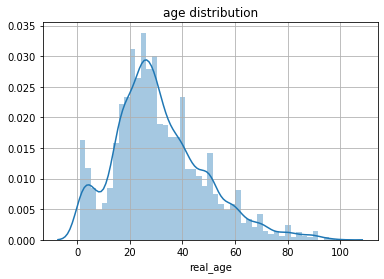

In [20]:
sns.distplot(labels.real_age, kde=True)
plt.grid(True)
plt.title('age distribution');

The age distribution is som like gamma distribution, which good for our purposes - making sure we dont sell alcohol to underage people. Although the mass is between 20-40 which are not underage... I would like to see the mass between 0-20, our algorithm would be better at identifying non-underages than identifying underages.

Plus I have outaires like a one year old baby or a 100 year old elderly they are not so relevant because the chances of them coming alone to buy alcohol is low, but I would like to be alerted if a five year old child is trying to buy so I will leave that big range for now.

**ploting images**

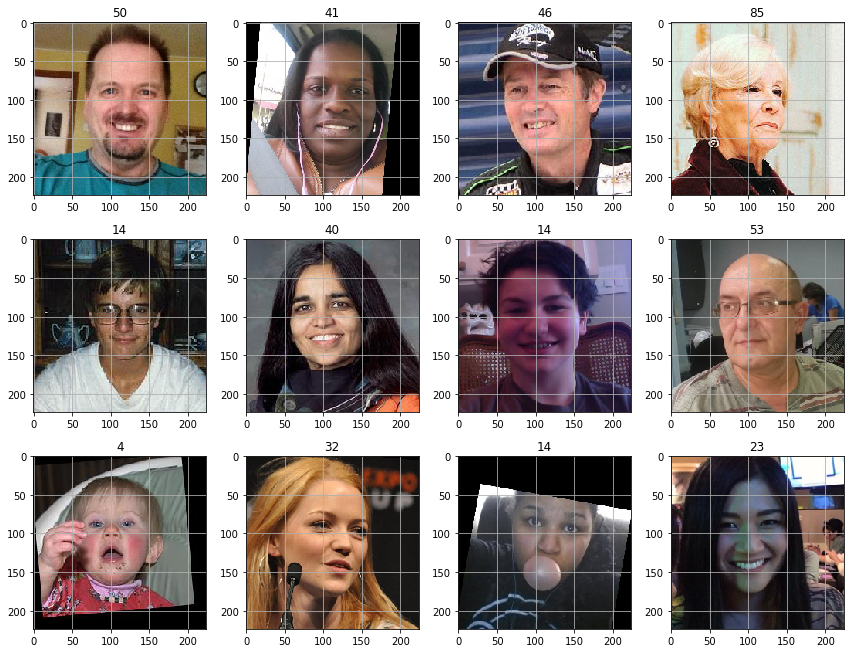

In [17]:
fig = plt.figure(figsize=(12,24))
for i in range(12):
    fig.add_subplot(8,4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.grid(True)
fig.tight_layout()

Image Data set looks very diverse in terms of age, gender and origin which reinforces the model.
The background of the image is basiclly noise and does not contribute to the model for predicting the age of the character. but because we want the model to work on new data as well, we need it to learn what relevant and whats not.

## Modelling

I will define functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

In [9]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1/255,
        horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,244),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    
    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1.0/255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow

In [11]:
def create_model(input_shape=(224, 224, 3)):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])
    
    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                  steps_per_epoch=None, validation_steps=None
               ):

    """
    Trains the model given the parameters
    """
    
    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             epochs=epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=step_per_epoch,
             validation_steps=validation_steps,
             verbose=2)
    
    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The code for data loading, model creation and training is correct. It's nice that you're augmenting the training data using horizontal flips (I support removing vertical flips though: human faces don't have that symmetry, and the upside-down face is not like a regular face because it has eyes below mouth for example)
	  
</div>

I am augmenting the training data set using horizontal flips,using a vertical flip would be a mistake because we do not expect to find inverted people in the supermarket, what is more the human faces don't have that symmetry, the neural network uses features such as a mouth below eyes to predict, vertical flips will disrupt the model, and cuts it so i have 0.25 validation to. 
After that I create a ResNet50 neural network backbone and add GlobalAveragePooling2D and Dense1 to get a regression output 
i use the relu activation function to get rid of the negative values and optimizer Adam with learning rate of 0.0005

## Prepare the Script to Run on the GPU Platform

In [13]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Output from the GPU platform:

Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 119 steps

Epoch 1/10
- 178/178 - 110s - loss: 198.6883 - mae: 10.5100 - val_loss: 514.1705 - val_mae: 17.6081

Epoch 2/10
- 178/178 - 38s - loss: 114.2769 - mae: 8.1078 - val_loss: 523.5679 - val_mae: 17.8237

Epoch 3/10
- 178/178 - 38s - loss: 90.5859 - mae: 7.2008 - val_loss: 473.4255 - val_mae: 16.6864

Epoch 4/10
- 178/178 - 37s - loss: 70.7201 - mae: 6.3631 - val_loss: 206.9530 - val_mae: 11.2742

Epoch 5/10
- 178/178 - 38s - loss: 54.5000 - mae: 5.5839 - val_loss: 101.7839 - val_mae: 7.4652

Epoch 6/10
- 178/178 - 37s - loss: 46.8688 - mae: 5.2320 - val_loss: 120.8870 - val_mae: 8.3172

Epoch 7/10
- 178/178 - 37s - loss: 43.4086 - mae: 5.0057 - val_loss: 81.2091 - val_mae: 6.7004

Epoch 8/10
- 178/178 - 38s - loss: 34.6991 - mae: 4.5056 - val_loss: 147.3814 - val_mae: 9.0652

Epoch 9/10
- 178/178 - 37s - loss: 28.8399 - mae: 4.1127 - val_loss: 83.4711 - val_mae: 6.7901

Epoch 10/10
- 178/178 - 37s - loss: 23.2032 - mae: 3.6992 - val_loss: 102.0375 - val_mae: 7.5944


119/119 - 9s - loss: 102.0375 - mae: 7.5944

Test MAE: 7.5944


## Conclusions

I used the ResNet50 neural network in order to predict age by face image, the traning set contains 5694 images and the tesing set contains 1897 images, my final MAE score is 7.5944